In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats

# Load data from a CSV file
data = pd.read_csv('Low Concentration Data.csv')

# Extract wavelength and intensity data
wavelength = np.array(data['nm lambda'])
intensities = data.iloc[:, 1:].values

# Filter data for specific wavelengths
mask = (wavelength > 450) & (wavelength < 750)
wavelength_filtered = wavelength[mask]
intensities_filtered = intensities[mask, :]
sample_count = intensities_filtered.shape[1]

# Data overview
print(f"Wavelength range: {wavelength.min():.1f} - {wavelength.max():.1f} nm")
print(f"Wavelength range (filtered): {wavelength_filtered.min():.1f} - {wavelength_filtered.max():.1f} nm")
print(f"Number of samples: {sample_count}")
print(f"Data shape: {intensities.shape}")

Wavelength range: 0.0 - 894.9 nm
Wavelength range (filtered): 450.1 - 749.9 nm
Number of samples: 8
Data shape: (4096, 8)


In [199]:
# Define parameters for concentration calculation
m, d_m = 0.09, 0.01       # Mass of Blue FCF (g)
V0, dV0 = 0.5042, 0.0001  # Total volume (L)
m_m = 792.85              # Molar mass of Brilliant Blue FCF (g/mol)
delta_pip = 0.00003       # Pipette error (L)
dvolume = 0.0001          # Taking volume error as 0.1ml (L)
 
# Main mixture concentration and error
c0 = m / (m_m * V0) * (0.85)  # molar concentration (mol/L) (~ 1.9136 e-4)
delta_c0 = (1 / (m_m * V0)) * np.sqrt(d_m**2 + (m * dV0 / V0)**2)

# First solution (i.e. reference solution)concentration and error
print(f"Main mix:  c₀ = {c0:.6e} ± {delta_c0:.6e} mol/L  (rel: {delta_c0/c0*100:.1f}%)")


def dilute(c0, dc0, V_taken, dV_taken, V_total, dV_total):
    """
    The second error propagation function
    Calculates the error in concentration after dilution
    """
    
    c1 = c0 * V_taken / V_total
    dc1 = (1/V_total) * np.sqrt((c0 * dV_taken)**2 
                                + (V_taken * dc0)**2 
                                + (c0 * V_taken * dV_total / V_total)**2)

    return c1, dc1


"""
Dilution steps to get to the first solution 3/32 of c0
Step 1: 1/2 dilution (100mL solution + 100mL water = 200mL)
Step 2: 1/4 dilution (100mL of step1 + 300mL water = 400mL)
Step 3: 3/4 dilution (150mL of step2 + 50mL water = 200mL)
All volumes in L
For dV_total add indepedent errors (from table 2.1 in lab error analysis manual)
 - Step 1: sqrt(dvolume ^2 + dvolume^2) - 2 pours
 - Step 2: sqrt(dvolume ^2 + dvolume^2 + dvolume^2 + dvolume^2) - 4 pours
 - Step 3: sqrt((1.5*dvolume) ^2 + (0.5*dvolume)^2) - 3 pours (one with 150mL, one with 50mL)
"""
c1, dc1 = dilute(c0, delta_c0, V_taken=0.1, dV_taken=dvolume, V_total=0.2, dV_total=np.sqrt(2)*dvolume)
c2, dc2 = dilute(c1, dc1, V_taken=0.1, dV_taken=dvolume, V_total=0.4, dV_total=2*dvolume)
c3, dc3 = dilute(c2, dc2, V_taken=0.15, dV_taken=1.5*dvolume, V_total=0.2, dV_total=np.sqrt(3)*dvolume)

c_first, dc_first = c3, dc3


"""
Calculate concentrations and errors for solutions 2-8
"""
# Dilution ratios i.e. first solution volume (mL): water volume (mL) except for solution 1
solution_ratios = {9:1, 8:2, 7:3, 6:4, 5:5, 4:6, 3:7}

# Calculate and store in a dictionary
concentrations = {1: (c_first, dc_first)}
for i, (sol, water) in enumerate(solution_ratios.items()):
    c, dc = dilute(c_first, dc_first,
                   V_taken=sol/1000, dV_taken=delta_pip,
                   V_total=0.01, dV_total=np.sqrt(2)*delta_pip)
    concentrations[i+2] = (c, dc)

for solution, (c, dc) in concentrations.items():
    print(f"Solution {solution}: c = {c:.3e} ± {dc:.3e} mol/L  ({dc/c*100:.2f}%)")


Main mix:  c₀ = 1.913672e-04 ± 2.501536e-05 mol/L  (rel: 13.1%)
Solution 1: c = 1.794e-05 ± 2.345e-06 mol/L  (13.07%)
Solution 2: c = 1.615e-05 ± 2.113e-06 mol/L  (13.08%)
Solution 3: c = 1.435e-05 ± 1.878e-06 mol/L  (13.09%)
Solution 4: c = 1.256e-05 ± 1.644e-06 mol/L  (13.09%)
Solution 5: c = 1.076e-05 ± 1.409e-06 mol/L  (13.09%)
Solution 6: c = 8.970e-06 ± 1.175e-06 mol/L  (13.09%)
Solution 7: c = 7.176e-06 ± 9.402e-07 mol/L  (13.10%)
Solution 8: c = 5.382e-06 ± 7.061e-07 mol/L  (13.12%)


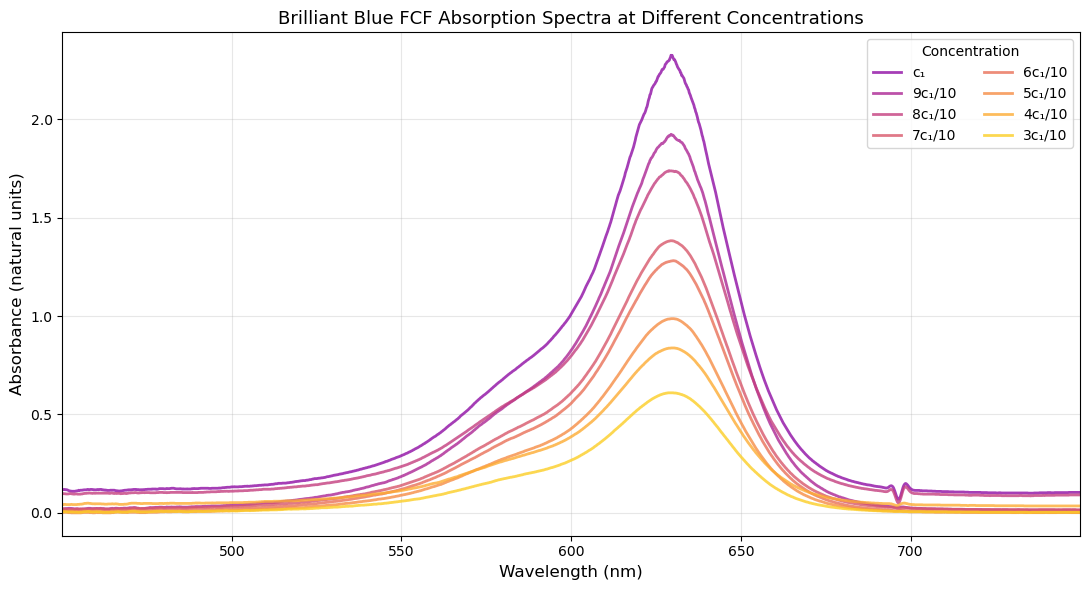

In [200]:
# PLot absorbance vs wavelength for each concentration
plt.figure(figsize=(11, 6))
colors = plt.cm.plasma(np.linspace(0.3, 0.9, 8))

labels = ['c₁', '9c₁/10', '8c₁/10', '7c₁/10', '6c₁/10', '5c₁/10', '4c₁/10', '3c₁/10']
# plot the absorption spectra
for i in range(sample_count):
    plt.plot(wavelength_filtered, intensities_filtered[:, i], label=labels[i], color=colors[i], linewidth=2, alpha=0.8)

# Label the plots
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Absorbance (natural units)', fontsize=12)
plt.title('Brilliant Blue FCF Absorption Spectra at Different Concentrations', fontsize=13)
plt.legend(title='Concentration', ncol=2)
plt.grid(alpha=0.3)
plt.xlim(wavelength_filtered.min(), wavelength_filtered.max())
plt.tight_layout()

# Save figure
plt.savefig('Absorption Spectra.png', dpi=300)

Wavelength corresponding to peak index for most concentrated sample: 628.5 nm
Sample 1: Absorbance = 2.2950 at Wavelength = 628.5 nm
Sample 2: Absorbance = 1.9130 at Wavelength = 628.5 nm
Sample 3: Absorbance = 1.7360 at Wavelength = 628.5 nm
Sample 4: Absorbance = 1.3800 at Wavelength = 628.5 nm
Sample 5: Absorbance = 1.2760 at Wavelength = 628.5 nm
Sample 6: Absorbance = 0.9850 at Wavelength = 628.5 nm
Sample 7: Absorbance = 0.8360 at Wavelength = 628.5 nm
Sample 8: Absorbance = 0.6100 at Wavelength = 628.5 nm

Linear regression results:
 - Slope: 129640.21743 ± 6254.21119
 - Intercept: -0.13292 ± 0.07733



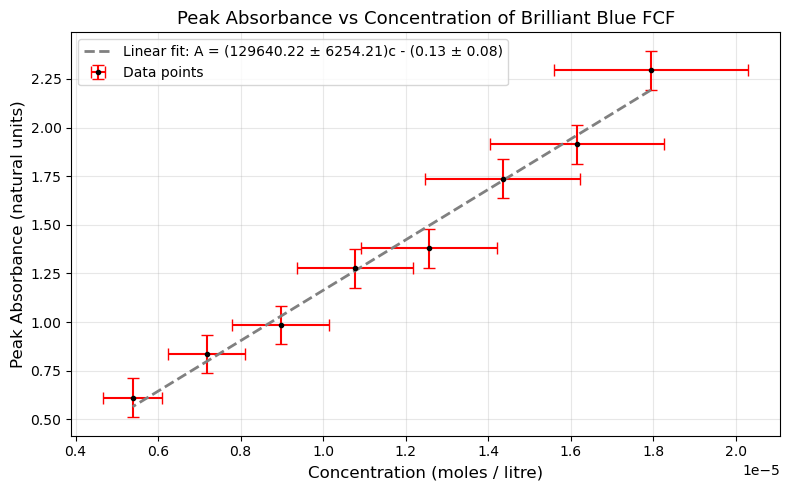

In [201]:
absorbance_error = 0.1  # Estimated
concentrations_array = np.array([c for c, dc in concentrations.values()])
dconcentrations_array = np.array([dc for c, dc in concentrations.values()])

# Find index of the concentration sample's peak absorption
peak_index = intensities_filtered[:, 7].argmax()
print(f"Wavelength corresponding to peak index for most concentrated sample: {wavelength_filtered[peak_index]:.1f} nm")

# Find and store absorbances of all samples for the same wavelength as the most concentrated sample's peak
absorbances = []
for sample in range(sample_count):
    absorbance = intensities_filtered[:, sample][peak_index]
    absorbances.append(absorbance)

    print(f"Sample {sample + 1}: Absorbance = {absorbance:.4f} at Wavelength = {wavelength_filtered[peak_index]:.1f} nm")

# Plot peak absorption vs concentration
plt.figure(figsize=(8, 5))
plt.errorbar(concentrations_array, absorbances, xerr=dconcentrations_array, yerr=absorbance_error, fmt='o', color='black', ecolor='red', capsize=4, markersize=3, label='Data points')

# Obtain linear regression results with errors
regression_stats = stats.linregress(concentrations_array, absorbances)
slope = regression_stats.slope
intercept = regression_stats.intercept
intercept_error = regression_stats.intercept_stderr
slope_error = regression_stats.stderr
print(f"\nLinear regression results:\n - Slope: {slope:.5f} ± {slope_error:.5f}\n - Intercept: {intercept:.5f} ± {intercept_error:.5f}\n")

# Plot best fit line with equation and errors in the legend
best_fit = slope * concentrations_array + intercept
plt.plot(concentrations_array, best_fit, linestyle='--', linewidth=2, color='grey',
         label=f'Linear fit: A = ({slope:.2f} ± {slope_error:.2f})c {"" if intercept >= 0 else "-"} ({abs(intercept):.2f} ± {intercept_error:.2f})')

# Plot labels and formatting
plt.xlabel('Concentration (moles / litre)', fontsize=12)
plt.ylabel('Peak Absorbance (natural units)', fontsize=12)
plt.title('Peak Absorbance vs Concentration of Brilliant Blue FCF', fontsize=13)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Save figure
plt.savefig('Peak Absorbance vs Concentration.png', dpi=300)

In [202]:
# 2. Chi-Square calculation (Absorbance error only)
predicted_absorbances = slope * concentrations_array + intercept
chi_square = np.sum(((absorbances - predicted_absorbances) / absorbance_error)**2)

# Degrees of freedom (2 parameters: slope and intercept)
dof = len(absorbances) - 2
reduced_chi_square = chi_square / dof

print(f"Chi-Square: {chi_square:.4f}")
print(f"Reduced Chi-Square: {reduced_chi_square:.4f}")

Chi-Square: 3.1727
Reduced Chi-Square: 0.5288
